# Organization

## Inputs to interpolation
* ufo_locs_mod.F90
    * provides inputs to interpolation (lat, lon, time, etc)
* ufo_variables_mod.F90
    * more inputs to interpolation (T, humidity, etc.)
    * need to inprove specificity (e.g., is humidity RH or specific humidity)
    
## Outputs from interpolation
* ufo_geo_vals.F90

## Internal data structures
* ufo_obs_data_basis.F90
    * don't want these directly accessed by API
* ufo_obs_data.F90
    * this module will get replaced with the work that I do

# Class diagram

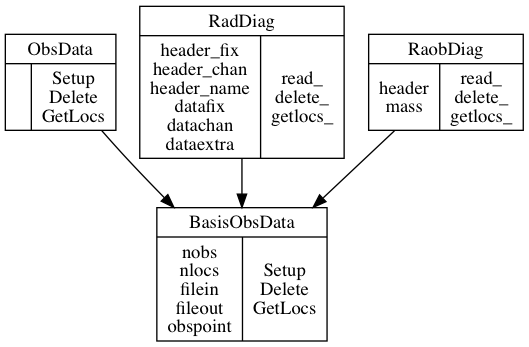

* Class ObsData is used to fill in deferred methods (Setup, Delete, GetLocs)
* Classes RadDiag and RaobDiag are used for creating obs objects

## Example
* ufo_radiance_mod.F90 creates an instance (obss) of ObsData, then it sets the obspoint pointer to the type Radiance which is a pointer to an instance of RadDiag
    * RadDiag inherits from BasisObsData
    * ObsData inherits from BasisObsData
* You end up with an instance of ObsData, that points to an instance of RadDiag
    * Why not make the inheritance go from BasisObsData --> ObsData --> RadDiag  
         OR
    * Put the specific Setup, Delete, GetLocs routines in RadDiag and skip the ObsData layer


# Meeting with Yannick, 1/5/18
* Anna is currently active on UFO development
* Current UFO has 2 types of observations implemented
    * We will likely end up with 30+ observation types
        * Radiance
        * Radiosonde
    * We want to work out the kinks with only a handful of observation types, then quickly put in the remaining types at the end
* Design questions
    * Can we replace obs data structure with ODB or something like ODB?
        * ODB can access netcdf
    * Can we get rid of UFO's dependence on netcdf?
        * Currently hardwired to netcdf
        * Want to have a more generic interface to file storage
    * Abstraction of:
        * Storage in files
        * Storage in memory
            * hide arrays, structs, etc.
* Class structure seems too heavy to Yannick too
    * Probably don't need the BasisObsData class
        * It doesn't provide much
        * However, it might turn out that there is a lot of commonality that would justify using this class
    * The ObsData class seems out of place
        * The Setup method is an indicator of this
            * It checks "what am I", and branches to different routines depending on the answer
            * Instead, the branches should just be the Setup routines in the specific obs classes
                * Radiance
                * Radiosonde
* In repository:
    * Make a branch to test out:
        * Simpler class structure
        * Other ideas
    * Test cases reside in the top level directory "test"

# Notes, 1/11/18
* Met with Anna yesterday (1/10/18)
    * She builds UFO inside container
        * Container is Docker
        * pick up ecbuild this way
    * Does not use jedi-bundle
    * Need four packages
        * oops, branch: features/ufo
        * idoa, branch: develop
        * crtm, branch: master
        * ufo, branch: develop
    * Run ctest after each compile
* Container is Singularity
    * Looks like I messed up the compiler scheme by loading anaconda
    * The fortran module files in /usr/local/include for fckit are not compatible with anaconda gcc
        * Anaconda gcc is version 4
        * Installed gcc in container is version 7
        * fckit was built with version 7
    * Need to be careful to build eckit, fckit with same gcc version that will be used for the UFO build
    * Ran into problems with jedi-bundle
        * Could not compile oops due to unresolved references into the boost library
    * Decided to try to build without jedi-bundle first
        * oops
            * clone in ~/projects, switch to branch feature/ufo
            * cd oops; mkdir build; cd build
            * ecbuild --build=release -DLAPACK_LIBRARIES=\$LAPACK_LIBRARIES ~/project/oops
            * make
            * ctest
                * All tests pass
        * crtm
            * clone in ~/projects, switch to branch master
            * cd crtm; mkdir build; cd build
            * ecbuild ~/projects/crtm
            * make
            * ctest
                * No tests found
        * ioda
            * clone in ~/projects, switch to branch develop
            * cd ioda; mkdir build; cd build
            * ecbuild ~/projects/ioda
            * make
            * ctest
                * No tests found
        * ufo
            * clone in ~/projects, switch to branch develop
            * cd ufo; mkdir build; cd build
            * ecbuild -DIODA_PATH=~/projects/ioda/build -DCRTM_PATH=~/projects/crtm/build -DOOPS_PATH=~/projects/oops/build ~/projects/ufo
            * make
            * ctest
                * first three tests pass
                * last two test fail, both with SEGFAULT errors
    * Try jedi-bundle
        * Remove ~/anaconda3/bin from path
            * Must have been something in anaconda that was supposed to be grabbed from somewhere else
        * clone in ~/projects, switch to branch master
        * cd jedi-bundle; mkdir build; cd build
        * ecbuild ~/projects/jedi-bundle
        * make
        * ctest
            * This runs the oops tests and the ufo tests
            * All tests pass!
    * What's missing from manual build?
        * Appears to be a connection to CRTM (breaks in manual space, works in jedi-bundle space)
        * Bad symlinks in build/ufo/test/Data directory
            * These links go into the crtm directory and select either little endian or big endian versions of binary files
        * The specification of how to build these symlinks is in ufo/test/CMakeLists.txt
            * Depend on the variable crtm_SOURCE_DIR being set (to the directory where crtm was cloned)
            * In the jedi-bundle case, crtm_SOURCE_DIR gets set by the ecbuild/cmake system
            * In the manual case, nothing sets crtm_SOURCE_DIR, but it can be set manaualy
                * ecbuild -Dcrtm_SOURCE_DIR=\$HOME/projects/crtm ...
                    * must be done this way for ecbuild/cmake to pick up
    * Fix for manual build:
        * Add "-Dcrtm_SOURCE_DIR=\$HOME/projects/crtm" to the ecbuild command
* Try outside container
    * anaconda in PATH messes things up
    * Use gcc6 or gcc7
    * Need to build/install ecbuild, eckit, and fckit
        * ecbuild
            * clone ecbuild, branch: master
            * cd ecbuild; mkdir build; cd build
            * cmake ..
            * make
            * ctest
            * make install
        * Ditto for eckit and fckit
            * Do eckit before fckit
            * I had MPI test failures - perhaps because I have an old processor and single core machine?
    * jedi-bundle
        * clone jedi-bundle, branch: master
        * cd jedi-bundle; mkdir build; cd build
        * ecbuild ~/projects/jedi-bundle
        * make
        * ctest

# Notes, 1/18/18
* If you build eckit and fckit before installing eigen
    * The build looks like it ran okay, BUT
    * eckit and fckit will not get the eigen include path (/usr/local/include/eigen3) set properly which causes the subsequent oops compile to fail.
* Use ecbuild to run cmake for eckit and fckit
    * check messages in ecbuild.log
* When installing boost, need to force brew to use same compiler that is used to compile oops
    * Two different c++ compilers can result in the name mangling for routines to be different
    * brew install boost
        * Uses the brew environment c++ compiler which does not support the c++11 standard
            * boost is compiled using the clang c++ compiler which does not utilize the c++11 standard
                * This might be something that can be added to ecbuild, but it's better to use the same compiler for boost and oops
        * When compiling oops, the brew installed gcc compiler is used: gcc-7
        * This mismatch results in the boost libraries having different mangled names for routines than those in the oops object files, which causes the link step to fail
    * The fix for this is to tell brew to use gcc-7 for compiling boost
        * brew install --cc=gcc-7 boost
* brew --env
    * shows which compilers brew will use for compiliation, search paths, etc.
* When debugging errors during make, can see the commands being executed by:
    * make VERBOSE=1

# Notes, 1/19/18

## Building UFO outside the container on OS X

* Don't use anaconda
    * Install python3 with homebrew instead
    * Good instructions for installing python with brew:
        * https://www.davidculley.com/installing-python-on-a-mac/
* Use homebrew to install software on the mac
    * Install homebrew itself:
        * /usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
    * Packages to install:
        * gcc
        * cmake
        * hdf5
        * netcdf
        * eigen
        * boost
            * use gcc-7 for compilation (--cc=gcc-7)
        * jupyter
            * for notebooks
        * macvim
            * nice GUI version of vi
        * mpich
        * graphviz
            * for making diagrams, flow charts, etc.
        * python
        * python3
        * tkdiff
            * nice GUI version of diff
        * iterm2
            * nice terminal emulator
* Order to install/build packages is:
    1. install eigen
        * brew install eigen
    1. install boost
        * brew install --cc=gcc-7 boost
    1. build ecbuild
        * clone ecbuild, branch = master
        * cd ecbuild
        * mkdir build
        * cd build
        * cmake ~/projects/ecbuild
        * make -j4
        * make install
    1. build eckit
        * clone eckit, branch = master
        * cd eckit
        * mkdir build
        * cd build
        * ecbuild ~/projects/eckit
        * make -j4
        * ctest
        * make install
    1. build fckit
        * clone fckit, branch = master
        * cd fckit
        * mkdir build
        * cd build
        * ecbuild ~/projects/fckit
        * make -j4
        * ctest
        * make install
    1. build crtm
        * clone crtm, branch = master
        * cd crtm
        * mkdir build
        * cd build
        * ecbuild ~/projects/crtm
        * make -j4
        * ctest
    1. build oops
        * clone oops, branch = feature/ufo
        * cd oops
        * mkdir build
        * cd build
        * ecbuild ~/projects/oops
        * make -j4
        * ctest
    1. build ioda
        * clone ioda, branch = develop
        * cd ioda
        * mkdir build
        * cd build
        * ecbuild ~/projects/oops
        * make -j4
        * ctest
    1. build ufo
        * clone ufo, branch = develop
        * cd ufo
        * mkdir build
        * cd build
        * ecbuild -Dcrtm_SOURCE_DIR=\$HOME/projects/crtm -DIODA_PATH=\$HOME/projects/ioda/build -DCRTM_PATH=\$HOME/projects/crtm/build -DOOPS_PATH=\$HOME/projects/oops/build ~/projects/ufo
        * make -j4
        * ctest